In [194]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t 
import seaborn as sns
import matplotlib.patches  as patches
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
sns.set_style('whitegrid')
random.seed(30)
np.random.seed(30)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Normality Assumption

- We have the assumption that the distribution of the means $\Delta$ follows a normal distribution. 

## Why is it important?
- We have the assumption that the distribution of the means follows a normal distribution. This is a strong assumption to have and needs to be tested/ensured before further methods. Why is that so? Well, a 1.96 * Standard error estimates the population to be within 95% confidence interval in a normal distribution.

For example, let us consider an event where we are interested in knowing what is in the 5% of a probability distribution and we assume our distribution to be normal when it is not. You can clearly observe from the plot below that the areas under the curve are vastly different. __Any statistic we would calculate under the assumption would be wrong__

In [2]:
def compare_plot(df,alpha):
    critical_value = stats.t.ppf(1.0 - alpha, df)
    f, ax = plt.subplots(1)
    ax.set_ylim(bottom=0,top=0.41)
    x = np.linspace(stats.t.ppf(0.01, df),
                    stats.t.ppf(0.99, df), 100)
    plt.plot(x, stats.t.pdf(x, df), color = 'r', label =f'$t-distribution$ with df 3 (not normal)')
    plt.fill_between(x=np.arange(-4.54,-critical_value,0.01),
                     y1= t.pdf(np.arange(-4.54,-critical_value,0.01), df),
                        facecolor='r',
                        alpha=0.5)     
    plt.text(x=(-critical_value-4.54)/1.7, y=0.04, color='red',size='large', s= f'$Area = {alpha}$')
    # plotting standard normal distribution
    x_axis = np.arange(-4, 4, 0.01)
    plt.plot(x_axis, stats.norm.pdf(x_axis,0,1), color ='b', label = f'$z- distribution$ (normal)')
    
    plt.fill_between(x=np.arange(-4,-critical_value,0.01), 
                y1= stats.norm.pdf(np.arange(-4,-critical_value,0.01)),
                facecolor='b',
                alpha=0.5)
    plt.axvline(x=-critical_value, color = "black", alpha=0.5,linestyle='--')
    plt.text(x=-critical_value, y=0.04, size='large',color='b', s= f'$Area = {round(stats.norm.cdf(-critical_value),3)}$')
    plt.legend()
    plt.title('Error due to incorrect Assumption of Normal Distribution')

__If we would have assumed our 't-distribution with 3 df' to be normal and had applied normal distribution formula to it to obtain the area of the curve (here, p-value), it would have been 0.061 or 6.1%. However, The true area would have been 0.11 which is 11%. Our calculation in the area would have been off by 4.9% which is a significant error and any inference that would follow would have serious flaw in it__ 

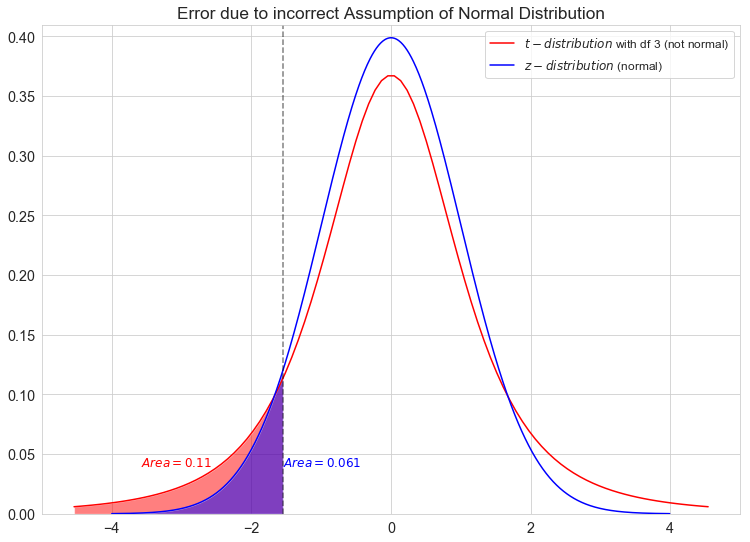

In [39]:
compare_plot(3,0.11)

## Tests for Normality:

## DO BOX PLOTS

### 1) Q-Q Plots:

Quantile plot is a grpahical tool to assess if the set of data came from a desired distribution. It is a scatterplot created by two sets of quantiles against one other. If both sets of quantiles came from the same distribution, we would see the points forming a line that is roughly straight. For Normal distribution, with a mean of 0. The 0.5 quantile, or 50th percentile, is 0. Half the data lie below 0. The 0.95 quantile, or 95th percentile, is about 1.64. Similarly, 95 percent of the data lie below 1.64. 
__We are comparing theoretical 'ideal normal distribution quantiles' with the observed one. If they line up, we have a normal distribution.  If our data adheres to the red 45 degree line, it’s normal or close to it, and if it does not, then it’s not normal.__

In [159]:
#generate data

#from normal dist
data1 = np.array([np.random.normal() for _ in range(1000)])

#from gamma dist with 1.1 scale 
data2 = np.array([np.random.gamma(1.1) for _ in range(1000)])

#from uniform dist 
data3 = np.array([np.random.uniform() for _ in range(1000)])

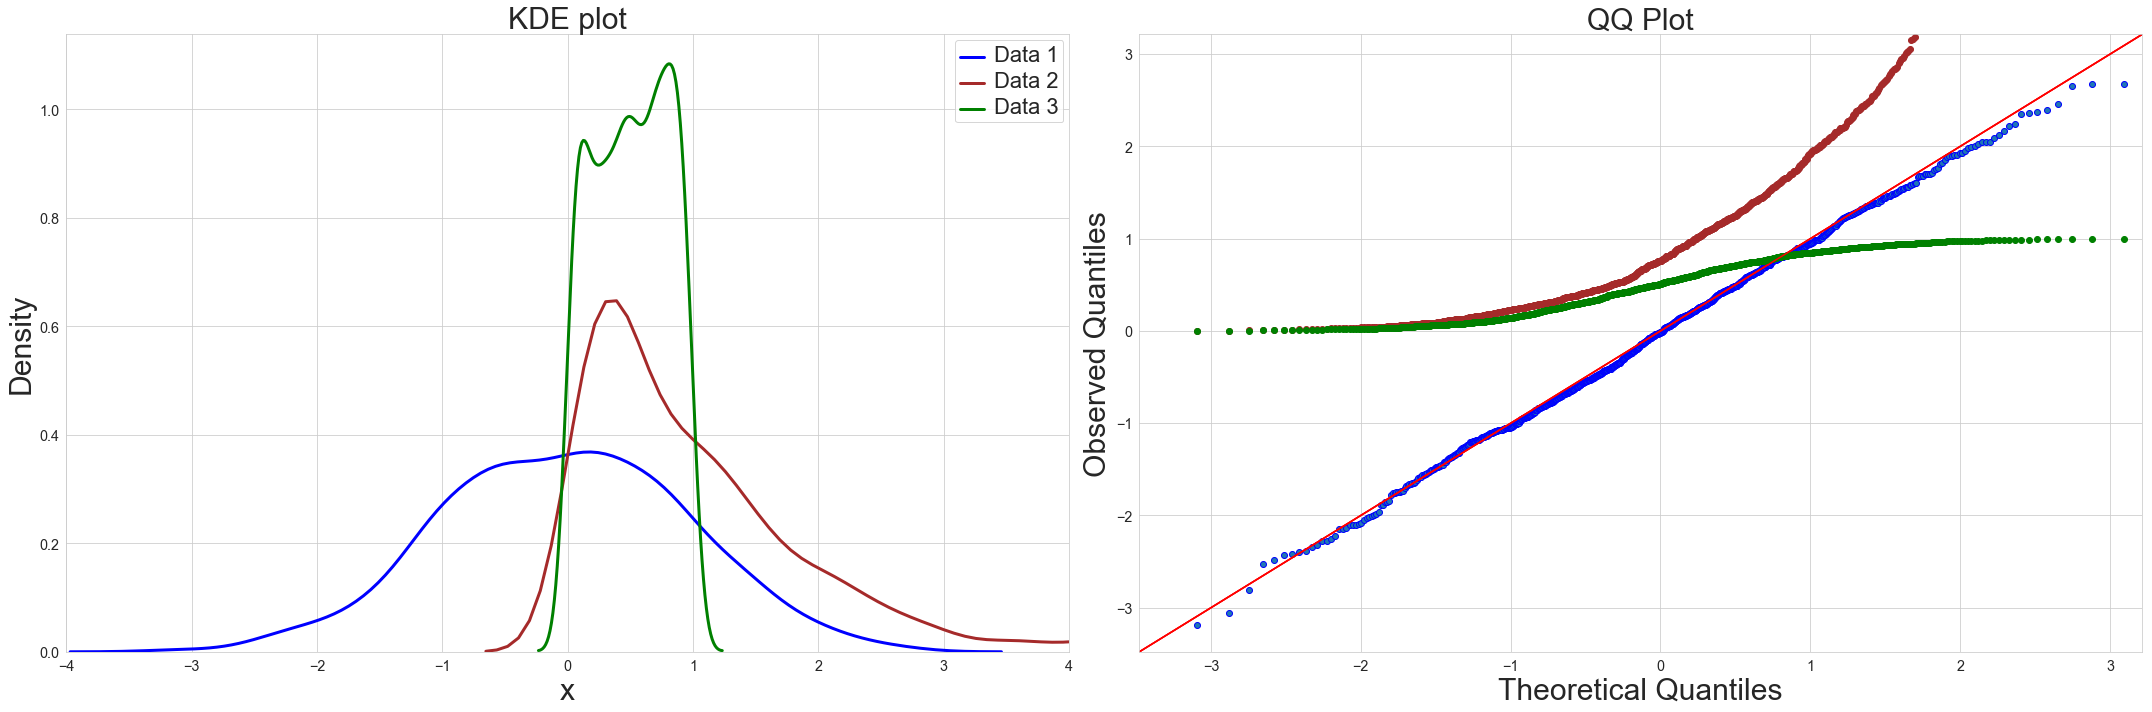

In [160]:
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('KDE plot', fontsize=30)
ax1.set_ylabel('Density', fontsize=30)
ax1.set_xlabel('x', fontsize=30)
ax1.set_xlim(left=-4,right=4)
sns.distplot(data1,hist=False ,kde_kws={"color": "blue", "lw": 3}, label='Data 1')
sns.distplot(data2,hist=False, kde_kws={"color": "brown", "lw": 3}, label='Data 2')
sns.distplot(data3 ,hist=False, kde_kws={"color": "green", "lw": 3},label='Data 3')
plt.setp(ax1.get_legend().get_texts(), fontsize='22')
ax2 = plt.subplot(1, 2, 2)
sm.qqplot(data1,ax=ax2,color='blue',line='45')
sm.qqplot(data2,ax=ax2,color='brown',line='45')
sm.qqplot(data3,ax=ax2,color='green',line='45')
ax2.get_lines()[0].set_markerfacecolor('C0')
ax2.set_title('QQ Plot', fontsize=30)
ax2.set_ylabel('Observed Quantiles', fontsize=30)
ax2.set_xlabel('Theoretical Quantiles', fontsize=30)

plt.subplots_adjust(hspace = 200)
plt.tight_layout()

## Empericial Distribution Function (EDF) tets:

_Empirical Distribution Function : The EDF is calculated by ordering all of the unique observations in the data sample and calculating the cumulative probability for each as the number of observations less than or equal to a given observation divided by the total number of observations. t's an estimate of the population cdf based on the sample; specifically if you treat the proportions of the sample at each distinct data value and treat it like it was a probability in the population, you get the ECDF.
Simply put, Empirical cumulative distribution function is a cumulative sum of frequencies of observed $x_{i}$ divided by total sample size_

__The distinction is which probability measure is used. For the empirical CDF, you use the probability measure defined by the frequency counts in an empirical sample.__

__The empirical CDF is built from an actual data set. The CDF is a theoretical construct - it is what you would see if you could take infinitely many samples.__

These tests check for the normality of the data by comparing the Empirical Distribution Function (EDF) of the observed data with the cumulative distribution function (CDF) of a normal distrubtion to see if there is a good agreement between them. 



The most famous ones are:
- Kolmogorov-Smirnov Test:
- Lilliefors Test
- Anderson-Darling Test

In the graph below, we can see that the sample we drew out the normal distribution most closely resembles the ideal CDF.

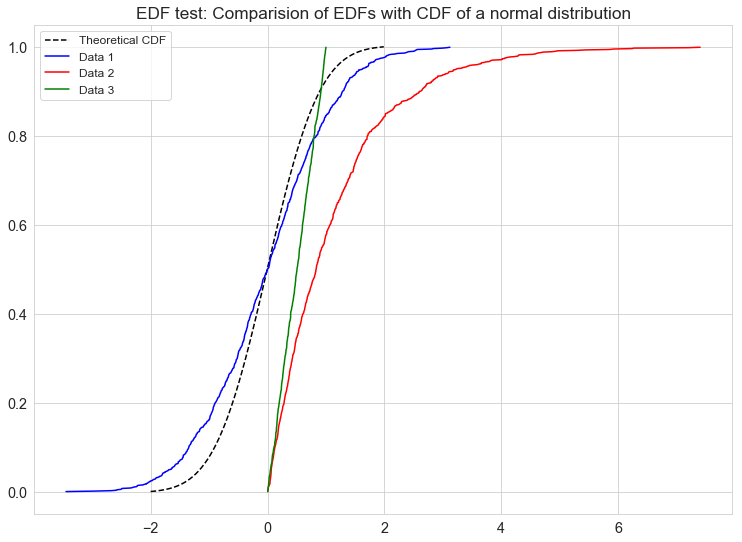

In [204]:
#theoretical ideal normal distribution
def cdf_normal(**kwargs):
    dx = 0.01
    X  = np.arange(-2, 2, dx)
    Y  = exp(-X ** 2)
    Y /= (dx * Y).sum()
    cdf = np.cumsum(Y * dx)
    plot(X, cdf, **kwargs)

def e_cdf(x, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    plt.plot(x, y, **kwargs)

 
cdf_normal(color='black', linestyle='--', label='Theoretical CDF')
e_cdf(normal_dist, color='blue', label='Data 1')
e_cdf(gamma_dist, color='red', label='Data 2')
e_cdf(uniform_dist, color='green', label='Data 3')
plt.title('EDF test: Comparision of EDFs with CDF of a normal distribution')
plt.legend()

###  Kolmogorov-Smirnov Test:
Measures the largest distance between the EDF and the theoritical function. If the difference is larger than the critical-value for the KS statistic, you reject the null hypothesis. Where,

$T = sup_{x}\left | F^{*}(x) - F_{n}(x) \right |$
where, $sup_{x}$ stands for suprenum (greatest), $F^{*}(x)$ is the hypothesized distribution function (contextually a normal distribution) and $F_{n}(x)$ is the EDF estimated based on the random sample (our observed data).
The KS test of normality,  $F^{*}(x)$ is taken to be a normal distribution with known mean, $\mu$ and standard deviation $\sigma$ . 

The KS test statistic is meant for testing:

$H_{0} = F^{*}(x) = F_{n}(x)$ for all x from $- \infty$ to $\infty$ (Contextually, The data follows a uniform distribution) <br>
$H_{A} = F^{*}(x) \neq F_{n}(x)$ for all x from $- \infty to \infty$ for atleast one value of x  (Contextually, The data does not follow a uniform distribution)


for KS test statistic: _http://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/_

In [281]:
#KS test for data with len >= 50
def KS(data, plot=False):
    assert len(data) >= 50, 'for this example, provide data with length > 50'
    data = np.sort(data)
    #from ks_crit table for alpha 0.05, and len(data) >=50, 
    ks_crit = 1.35810/np.sqrt(len(data))
    #edf
    edf_data =  np.arange(len(data)) / len(data)
    #null
    cdf_null = [stats.norm.cdf(x) for x in data]

    #two-tailed-test
    diff = max(np.abs(cdf_null - edf_data))
    
    if diff > ks_crit:
        text = 'Reject Null : t-crit: {:.3f} >  max difference: {:.3f}'.format(ks_crit, diff )
    else:
        text = 'Fail to Reject Null  t-crit: {:.3f} < max difference: {:.3f}'.format(ks_crit, diff )
        
    if plot:
        plt.plot(data, edf_data, c = 'red', label='Observed EDF')
        plt.plot(data, cdf_null, c='green', label='Expected CDF')
        for x, edf_point, cdf_point in zip(data, edf_data, cdf_null):
            plt.plot([x, x], [edf_point, cdf_point], color='cornflowerblue', alpha=0.1)
        plt.legend()
        if normal:
            plt.title(text)
        else:
            plt.title(text)
            
    else:
        print(text)
    

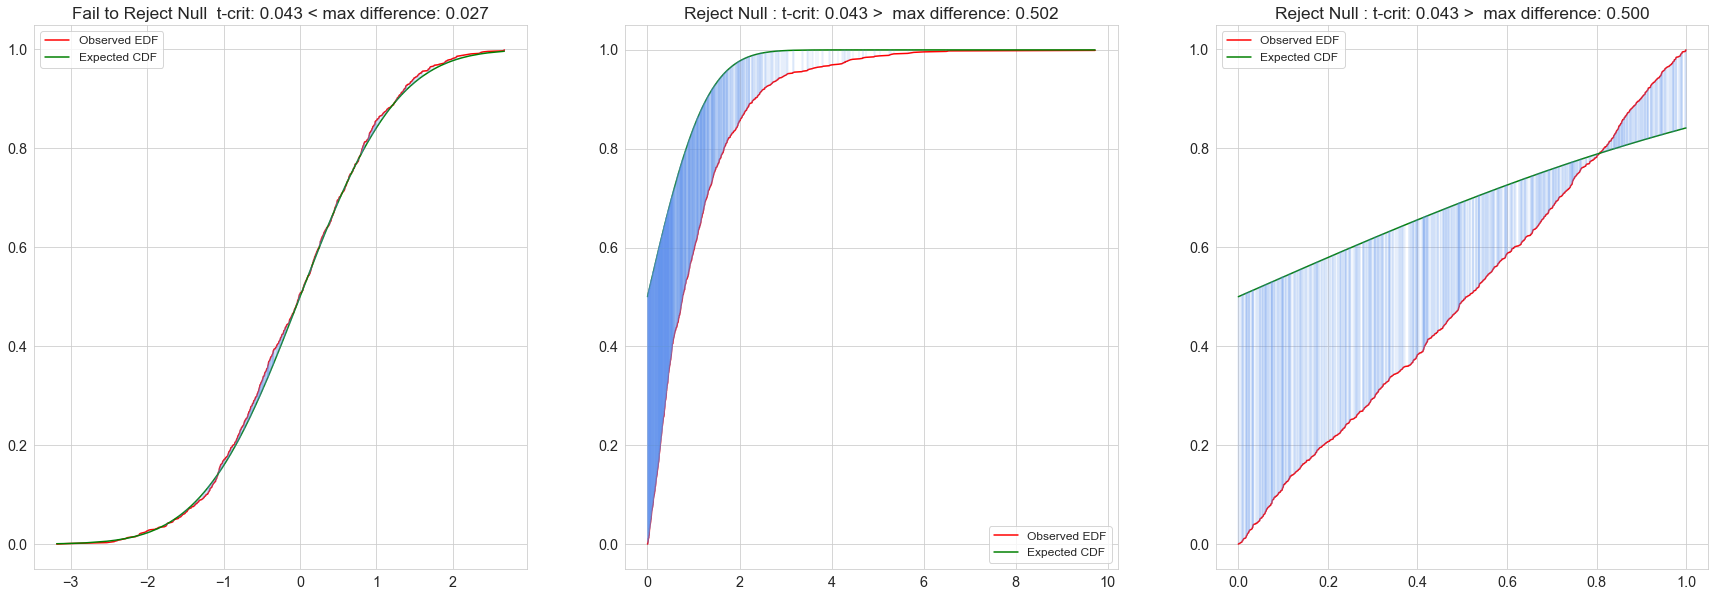

In [282]:
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 3, 1)
KS(data1, plot=True)
ax2 = plt.subplot(1, 3, 2)
KS(data2, plot=True)
ax2 = plt.subplot(1, 3, 3)
KS(data3, plot=True)


### Lilliefors Test:
It is the modificiation of the KS test. KS test is ideal for situations where the parameters of the hypothesized distribution are completely known. In contrast, the parameters for LF test are estimated based on the sample. It uses the same calculations as the KS test but the critical values are smaller, hence is less likely to show that data is normally distributed. In this case, Kolmogorov-Smirnov test based on the critical values in the Kolmogorov-Smirnov Table yields results that are too conservative. 

The Lilliefors test statistic are smaller so are less prone to type 1 errors.

$F^{*}(x)$ is taken to be a normal distribution with known mean, $\mu = \bar{X}$, the sample mean and standard deviation $s^{2}$ the sample variance. 

for Lilliefors test statistic: http://www.real-statistics.com/statistics-tables/lilliefors-test-table/


### Anderson-Darling Test:





## Regression and Correlation tests:
These are based on the ratio of two weighted least-quares estimate of scale obtained from other order statistics. The two estimates are the normally distributed weighted least quares estimates and the sample variance from other population.

The most famous one is :
- Shapiro-Wilk Test

### 1) Shaprio-Wilk Test:
Tets the null hypothsis that sample came from a normally distributed.

In [ ]:
from scipy.stats import shapiro
from scipy.stats import anderson 
from scipy.stats import kstest

stat, p = shapiro(control_means)
print('Statistics={}, p={}'.format(stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Normal (do not reject H0)')
else:
    print('Sample does not look Normal (reject H0)')
    
stat = anderson(control_means, dist='norm')
print('Statistics={}, p={}'.format(stat, p))

for i in range(len(stat.critical_values)):
    sl, cv = stat.significance_level[i], stat.critical_values[i]
    if stat.statistic < stat.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

stats.kstest(control_means, 'norm', N=999, alternative='two-sided')

# Have enough sample sizes.

One of the strategies to observe the $\Delta$ to follow a normal distribution is to have enough sample sizes. Let us illustrate an example of observing data from a $\gamma$ distribution. 
Let us take 1, 3, 10, 100, 200 samples each from the population and see how the $\Delta$ looks like 

In [ ]:
population = np.random.beta(8, 1, size=10000)

one,five,ten,hundred,thousand = [],[],[],[],[]
def sample_generator(plot='kde'):
    my_lists = [[],[],[],[],[]]
    sample_sizes = [1, 3, 10, 100, 200]
    
    for i,sample_size in enumerate(sample_sizes):
        for j in range(0,1000):
            sample_variant = random.choices(population, k=sample_size)
            mean = sum(sample_variant)/len(sample_variant)
            my_lists[i].append(mean)
        #idx += 1 
        #sns.distplot(my_lists[i] , color=colors[i], hist=False, label=f'$n = {sample_size}$')
    #f, ax = plt.subplots(1)
   # ax.set_ylim(bottom=0,top=0.41)
   # plt.legend()
    return my_lists
        
my_lists = sample_generator()

In [ ]:
# Import data
x1,x2,x3,x4,x5 = my_lists[0], my_lists[1], my_lists[2],my_lists[3],my_lists[4]
# plot
#fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
f, ax = plt.subplots(1)
ax.set_xlim(left=0.8,right=1.1)
sns.distplot(x1 , color="dodgerblue", hist=False, label=f'$n = 1$')
sns.distplot(x2 , color="deeppink", hist=False, label=f'$n = 3$')
sns.distplot(x3 , color="gold", hist=False, label=f'$n = 10$')
sns.distplot(x4 , color="green", hist=False, label=f'$n = 100$')
sns.distplot(x5 , color="black", hist=False, label=f'$n = 200$')

plt.title(f'Distribution of $\Delta$ approaches normal distribution with increased sample sizes')
plt.yticks([])
plt.xticks([])
plt.legend() 

In [304]:
x1.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
f, ax = plt.subplots(1)
qqplot(np.array(x1), ax = ax,line='s')
qqplot(np.array(x1), ax = ax,line='s')
qqplot(np.array(x1), ax = ax,line='s')
qqplot(np.array(x1), ax = ax,line='s')
qqplot(np.array(x1), ax = ax,line='s')

Power = Pr(reject H0 | H1 is true) = 1 - Pr(fail to reject H0 | H0 is false)

In [14]:

# parameters for the analysis 
effect_size = 0.5
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 63.77


# References:

[Power comparisons of Shapiro-Wilk, Kolmogorov-Smirnov, Liliefors and Anderson-Darling tets](https://www.researchgate.net/publication/267205556_Power_Comparisons_of_Shapiro-Wilk_Kolmogorov-Smirnov_Lilliefors_and_Anderson-Darling_Tests)